# Explore what happens if we permute the labels of the enhancer data

In this notebook, we explore what happens to the feature importance of RF when we permute the labels of the enhancer data. This exploration helps to understand the behavior of Gini importance when RF did not predict well. The finding is interesting: some features are more favored by RF than other features. This highlights the problem of using Gini importance to select "important" features for this dataset.

In [1]:
import rpy2.robjects as robjects
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from irf import irf_utils, irf_jupyter_utils

## read the data

In [2]:
tmp = robjects.r['load']('../iRF_analyses/data/enhancer.Rdata')
print(tmp)
X = robjects.r["X"]
XX = np.asarray(X)
print(XX)
assert(len(XX[0]) == X.ncol) #same number of cols
assert(len(XX) == X.nrow)
X = XX
Y = robjects.r["Y"]
Y = np.asarray(Y)
assert(len(Y) == len(X))
test = np.asarray(robjects.r["test.id"])
train = np.asarray(robjects.r["train.id"])
varnames = np.asarray(robjects.r["varnames.all"])

[1] "X"            "Y"            "test.id"      "train.id"     "varnames.all"

[[ 6.      10.      10.      ...  0.       0.       0.     ]
 [ 6.       7.       6.      ...  0.       0.       0.     ]
 [14.       9.      14.      ...  0.       0.       1.2013 ]
 ...
 [ 9.      12.      16.      ...  2.13176  2.22051  1.20134]
 [17.      18.      14.      ...  1.49709  1.39971  1.26398]
 [13.      15.      18.      ...  2.03769  2.03994  0.     ]]


## permute the labels

In [3]:
Y = np.random.permutation(Y)

## train test split

In [4]:
X_train = X[train-1,:]
X_test = X[test-1,:]
y_train = Y[train - 1]
y_test = Y[test - 1]

## train RF

In [8]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## plot the feature importance

<BarContainer object of 80 artists>

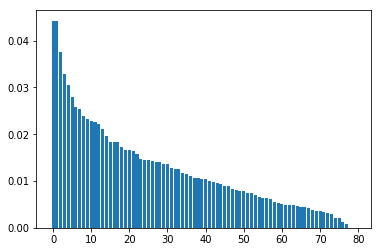

In [9]:
p = len(rf.feature_importances_)
plt.bar(x = list(reversed(range(p))), height = np.sort(rf.feature_importances_))

### repeat the permutation 100 times and record the frequency of the "most important” genes

In [11]:
n_trials = 400
records = []
for _ in range(n_trials):
    y_train = np.random.permutation(y_train)
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X_train, y_train)
    records.append(np.argmax(rf.feature_importances_))
vals, freqs = np.unique(records, return_counts=True)
print(varnames[1,vals], freqs)

['H3' 'H3K18ac' 'H3K18ac' 'H3K18ac' 'H3K27ac' 'H3K27me3' 'H3K27me3'
 'H3K27me3' 'H3K36me3' 'H3K36me3' 'H3K36me3' 'H3K4me1' 'H3K4me3' 'H3K4me3'
 'H3K4me3' 'H3K4me3' 'H3K9ac' 'H4K5ac' 'wt_H3' 'wt_H3K18ac' 'wt_H3K4me1'
 'wt_ZLD'] [  1   4   1   2   5  14  16  13  13   9   5   2  14   9   2   2   1   6
 112  47  74  48]


### Findings: even if the labels are permuted, ZLD appears at the top 15% times, H3K18ac appears 25% times, H3K4me1 appears 17% times. This shows the feature importance is not uniform across features when none of them is predictive.